In [1]:
from gensim.models.ldamodel import LdaModel
import gensim
import pandas as pd
import glob
from nltk.corpus import stopwords
import string
from gensim import corpora,models
from gensim.utils import lemmatize # Only keep nums
from gensim.corpora import Dictionary
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
import sys
import numpy as np
import enchant
%config InlineBackend.figure_format = 'retina'
import nltk
import itertools
from collections import Counter
import operator
import seaborn as sns

C:\Users\mnan\Anaconda3\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\mnan\Anaconda3\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [3]:
def process_text(content_list):
    """
    stopwords
    
    punctuation
    
    digits
    
    english words
    
    """
    typical_words = ['light','therapy','facial','skin','rt','treatment','face']
    stoplist = stopwords.words('english') + typical_words 
    
    remove_digits = str.maketrans('', '', string.digits)
    remove_punctuation = str.maketrans('', '', string.punctuation)
    
    dict_english = enchant.Dict("en_US")
    
    lemma = WordNetLemmatizer()
    
    content_cleaned =[i.translate(remove_digits) for i in content_list]
    
    content_cleaned = [i.translate(remove_punctuation) for i in content_cleaned]
    
    content_cleaned = [[lemma.lemmatize(word.lower()) for word in line.split()
                        if (word.lower() not in stoplist) and dict_english.check(word.lower())==True] for line in content_cleaned]

    return content_cleaned

In [4]:
content = pd.read_csv('text.csv',encoding = 'iso-8859-1',header=None)
content.columns = ['content']
print('initial length %d'%len(content))
content = content[content.duplicated('content',keep = 'first')] #deduplicate
print('after deduplicate %d'%len(content))
content = pd.DataFrame(list(filter(lambda x: 'Violet' not in x, content['content'].values)),columns = ['content'])  #ads
print('after ads filtering %d'%len(content))
content_list = content['content'].values
cleaned_list = process_text(content_list)
print('after text process %d'%len(cleaned_list))

initial length 8001
after deduplicate 3038
after ads filtering 2854
after text process 2854


In [6]:
corpus_with_pos = list(map(lambda x:nltk.pos_tag(x),cleaned_list))
flattened_corpus_with_pos = []
for sublist in corpus_with_pos:
    for val in sublist:
        flattened_corpus_with_pos.append(val)
flattened_cleaned_list = []
for sublist in cleaned_list:
    for val in sublist:
        flattened_cleaned_list.append(val)
flatterned_corpus_with_pos = nltk.pos_tag(flattened_cleaned_list)
deduplicated_df_pos = pd.DataFrame({'word':flattened_cleaned_list,'pos':list(map(lambda x:x[1],flatterned_corpus_with_pos))}).drop_duplicates(subset=['word'])
flattened_cleaned_list = []
for sublist in cleaned_list:
    for val in sublist:
        flattened_cleaned_list.append(val)

In [7]:
counts = Counter(flattened_cleaned_list).items()
df_word_cnt_pos = pd.DataFrame(sorted(counts,key = lambda x:x[1],reverse = True),columns = ['word','count']).merge(deduplicated_df_pos,on = ['word'])
df_word_cnt_pos.loc[5,'pos']='NN'
df_word_cnt_pos.loc[1,'pos']='NN'
df_word_cnt_pos.groupby('pos').count()
df_w_c_verb = df_word_cnt_pos[df_word_cnt_pos['pos'].isin(['VB','VBD','VBN','VBP','VBZ'])].sort_values('count',ascending = False)

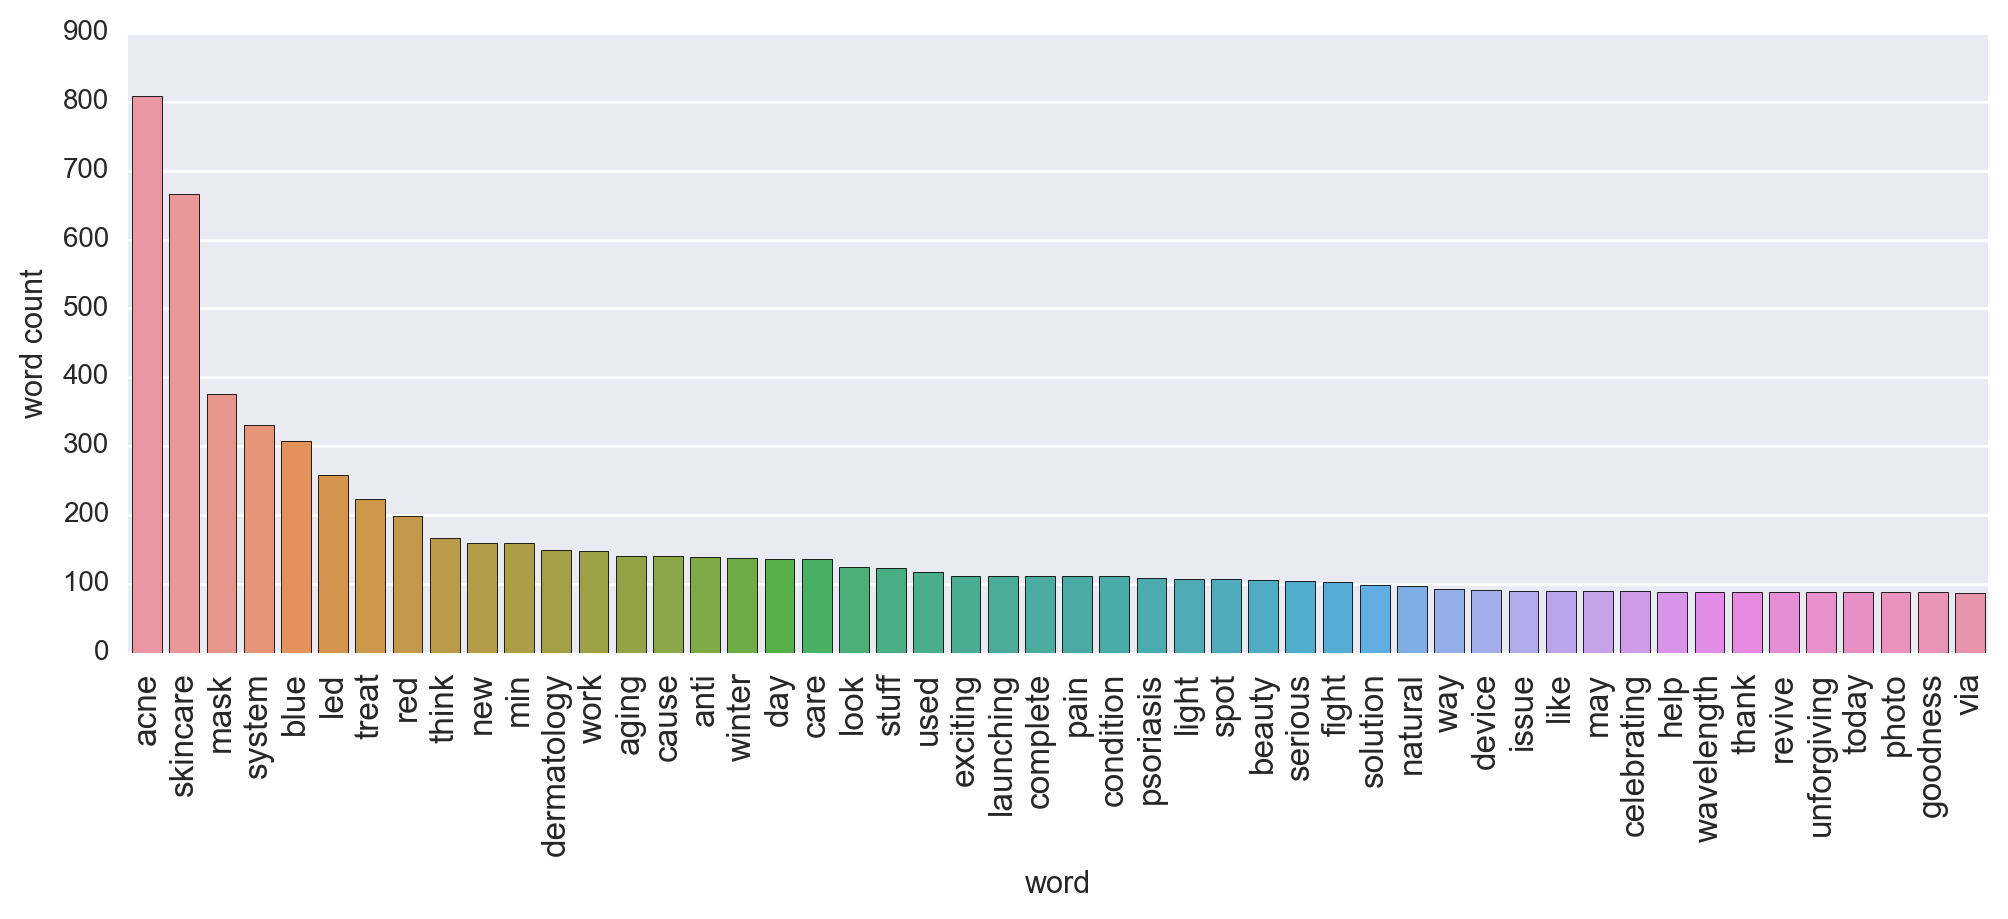

In [8]:
plt.figure(figsize=(12,4))
sns.barplot(data = df_word_cnt_pos[:50],x = 'word',y = 'count')
plt.xticks(rotation = 90,size = 12)
plt.ylabel('word count')

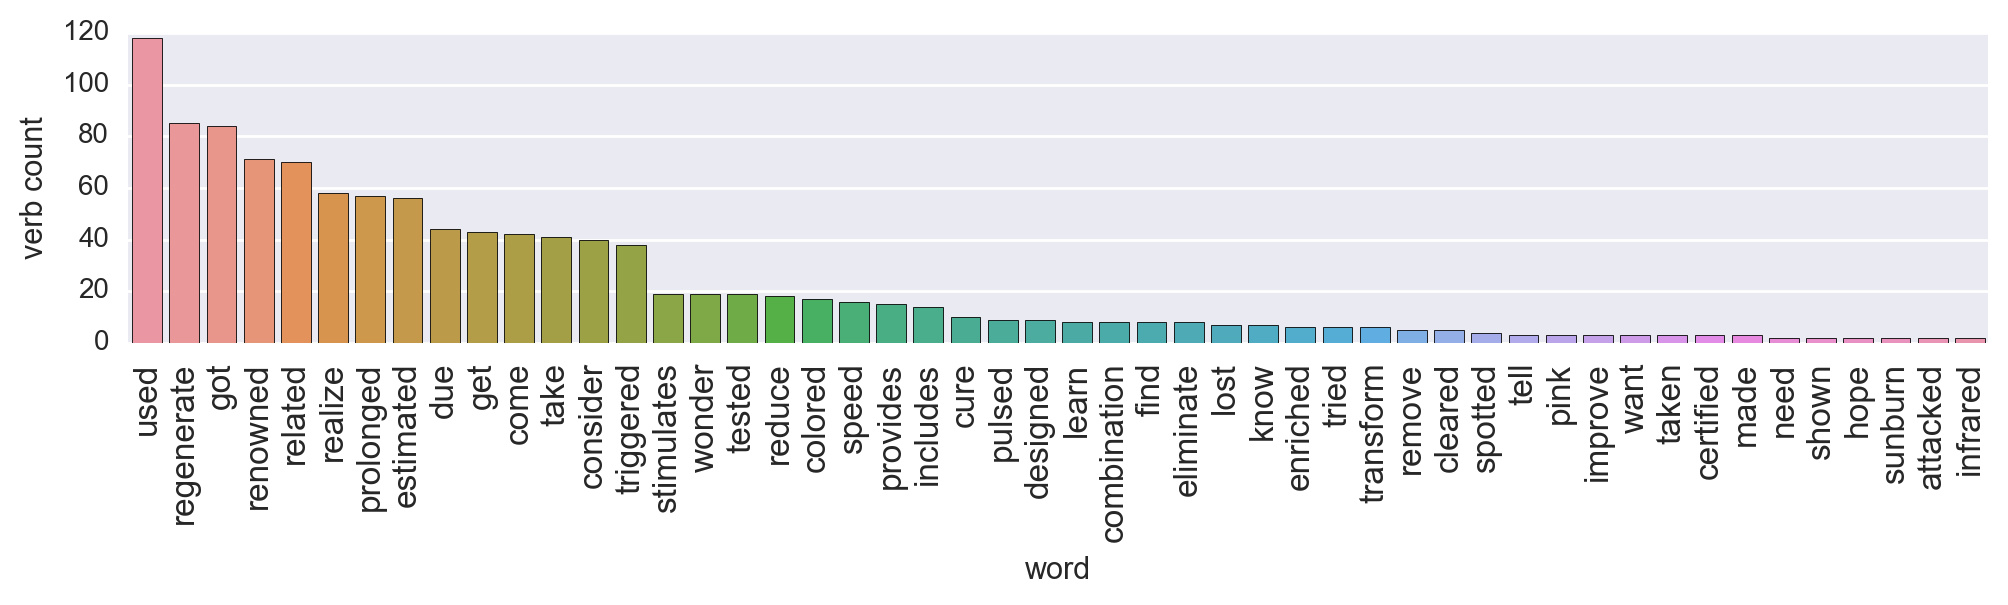

In [9]:
plt.figure(figsize=(12,2))
sns.barplot(data = df_w_c_verb[:50],x = 'word',y = 'count')
plt.xticks(rotation = 90,size = 12)
plt.ylabel('verb count')

In [10]:
print('In 8001 messges:')
for word in ['skincare','acne','think','look','used']:
    n = 0
    text_cnt = len(cleaned_list)
    for list in cleaned_list:
        if word in list:
            n+=1
    print("'%s' appeard %d times (%s)"%(word,n,round(n/text_cnt,3)))        

In 8001 messges:
'skincare' appeard 666 times (0.233)
'acne' appeard 761 times (0.267)
'think' appeard 84 times (0.029)
'look' appeard 125 times (0.044)
'used' appeard 115 times (0.04)


In [11]:
print('In 8001 messges:')
for word in ['red','blue','green','color']:
    n = 0
    text_cnt = len(cleaned_list)
    for list in cleaned_list:
        if word in list:
            n+=1
    print("'%s' appeard %d times (%s)"%(word,n,round(n/text_cnt,3)))

n = -1
n_list = []
for list in cleaned_list:
    n +=1
    if 'violet' in list:
        n_list.append(n)

In 8001 messges:
'red' appeard 194 times (0.068)
'blue' appeard 303 times (0.106)
'green' appeard 56 times (0.02)
'color' appeard 10 times (0.004)


33% messages mentioned LED and 24% acne

verd used much less than noun

In [12]:
n = 0
for list in cleaned_list:
    if 'skincare' in list:
        if 'acne' in list:
            n +=1
print("%d messages (%s) contain both 'skincare' and 'acne'"%(n,round(n/text_cnt,3)))       

38 messages (0.013) contain both 'skincare' and 'acne'


In [14]:
del(list)
cleaned_list_filtered = list(filter(lambda x: ('skincare' not in x) and ('acne' not in x),cleaned_list))
filtered = list(filter(lambda x: ('skincare' in x) or ('acne' in x),cleaned_list))
filtered_0 =[]
for i in filtered:
    if 'skincare' in i:
        i.remove('skincare')
    if 'acne' in i:
        i.remove('acne')
    filtered_0.append(i)

### Let's see messages with/without skincare or acne

** Build Dict **

without:

In [318]:
dictionary = Dictionary(cleaned_list_filtered)
corpus = [dictionary.doc2bow(text) for text in cleaned_list_filtered]
num_topics = 7
lda = LdaModel(corpus, num_topics= num_topics,id2word = dictionary)
lda.show_topics(num_topics,15)

[(0,
  '0.043*"spot" + 0.041*"age" + 0.040*"birthmark" + 0.040*"wish" + 0.040*"scarring" + 0.040*"freckle" + 0.040*"treat" + 0.040*"perfect" + 0.029*"red" + 0.023*"cause" + 0.016*"estimated" + 0.016*"affect" + 0.016*"million" + 0.016*"according" + 0.016*"wavelength"'),
 (1,
  '0.052*"aging" + 0.046*"anti" + 0.029*"fight" + 0.028*"problem" + 0.028*"way" + 0.028*"safest" + 0.028*"related" + 0.028*"probably" + 0.028*"renowned" + 0.026*"care" + 0.026*"natural" + 0.026*"like" + 0.025*"look" + 0.023*"remedy" + 0.021*"beauty"'),
 (2,
  '0.047*"lady" + 0.047*"inflammation" + 0.047*"green" + 0.047*"lovely" + 0.047*"edema" + 0.047*"reducing" + 0.040*"hair" + 0.027*"led" + 0.020*"mask" + 0.016*"technology" + 0.016*"laser" + 0.014*"day" + 0.014*"launching" + 0.014*"complete" + 0.014*"exciting"'),
 (3,
  '0.047*"cause" + 0.033*"red" + 0.032*"mask" + 0.032*"day" + 0.031*"exciting" + 0.031*"launching" + 0.031*"complete" + 0.030*"cell" + 0.030*"wavelength" + 0.030*"layer" + 0.030*"healthier" + 0.030*"

with:

In [412]:
dictionary_f = Dictionary(filtered_0)
corpus_f = [dictionary_f.doc2bow(text) for text in filtered_0]
num_topics = 3
lda_f = LdaModel(corpus_f, num_topics= num_topics,id2word = dictionary_f)
lda_f.show_topics(num_topics,15)

[(0,
  '0.121*"blue" + 0.090*"min" + 0.046*"led" + 0.045*"ride" + 0.045*"car" + 0.045*"score" + 0.043*"help" + 0.042*"prevent" + 0.036*"trophy" + 0.033*"new" + 0.033*"mask" + 0.032*"downtime" + 0.032*"pain" + 0.031*"needle" + 0.021*"acne"'),
 (1,
  '0.076*"solution" + 0.056*"mask" + 0.034*"blue" + 0.027*"new" + 0.024*"help" + 0.018*"healthy" + 0.017*"system" + 0.016*"transform" + 0.016*"revive" + 0.015*"review" + 0.014*"red" + 0.014*"device" + 0.014*"led" + 0.013*"acne" + 0.013*"learn"'),
 (2,
  '0.077*"mask" + 0.056*"goodness" + 0.056*"unforgiving" + 0.055*"photo" + 0.055*"light" + 0.055*"thank" + 0.051*"blue" + 0.025*"spot" + 0.020*"fight" + 0.019*"new" + 0.017*"device" + 0.016*"routine" + 0.016*"making" + 0.016*"proven" + 0.016*"celebrating"')]

** Save the model **

In [ ]:
import pickle
with open('lda.pickle', 'wb') as handle:
    pickle.dump(lda, handle, protocol=pickle.HIGHEST_PROTOCOL)

** Read the model **

In [15]:
import pickle
with open('lda.pickle', 'rb') as handle:
    lda = pickle.load(handle)

In [16]:
num_topics = 7
lda.show_topics(num_topics,15)[0][1].split('+')
import re
topic_word=dict()
for i in range(num_topics):
    topic_word[i]=[]
    for text in lda.show_topics(num_topics,15)[i][1].split('+'):
        topic_word[i].extend(re.findall('[a-z]+', text))

In [322]:
for i in range(7):
    print(topic_word[i])
    print('----------------')

['spot', 'age', 'birthmark', 'wish', 'scarring', 'freckle', 'treat', 'perfect', 'red', 'cause', 'estimated', 'affect', 'million', 'according', 'wavelength']
----------------
['aging', 'anti', 'fight', 'problem', 'way', 'safest', 'related', 'probably', 'renowned', 'care', 'natural', 'like', 'look', 'remedy', 'beauty']
----------------
['lady', 'inflammation', 'green', 'lovely', 'edema', 'reducing', 'hair', 'led', 'mask', 'technology', 'laser', 'day', 'launching', 'complete', 'exciting']
----------------
['cause', 'red', 'mask', 'day', 'exciting', 'launching', 'complete', 'cell', 'wavelength', 'layer', 'healthier', 'newer', 'create', 'regenerate', 'work']
----------------
['mask', 'new', 'wrinkle', 'look', 'many', 'people', 'rosy', 'even', 'prolonged', 'cheek', 'realize', 'led', 'device', 'like', 'freckle']
----------------
['used', 'condition', 'system', 'serious', 'psoriasis', 'treat', 'realize', 'people', 'cheek', 'rosy', 'prolonged', 'even', 'many', 'affect', 'million']
-------------

In [413]:
num_topics = 3
lda_f.show_topics(num_topics,15)[0][1].split('+')
import re
topic_word=dict()
for i in range(num_topics):
    topic_word[i]=[]
    for text in lda_f.show_topics(num_topics,15)[i][1].split('+'):
        topic_word[i].extend(re.findall('[a-z]+', text))
for i in range(3):
    print(topic_word[i])
    print('----------------')

['blue', 'min', 'led', 'ride', 'car', 'score', 'help', 'prevent', 'trophy', 'new', 'mask', 'downtime', 'pain', 'needle', 'acne']
----------------
['solution', 'mask', 'blue', 'new', 'help', 'healthy', 'system', 'transform', 'revive', 'review', 'red', 'device', 'led', 'acne', 'learn']
----------------
['mask', 'goodness', 'unforgiving', 'photo', 'light', 'thank', 'blue', 'spot', 'fight', 'new', 'device', 'routine', 'making', 'proven', 'celebrating']
----------------


In [ ]:
assign = []
for i in range(len(corpus)):
    assign.append(sorted(lda[corpus[i]],key = lambda x:x[1],reverse = True)[0][0])
conf_score = []
for i in range(len(corpus)):
    conf_score.append(sorted(lda[corpus[i]],key = lambda x:x[1],reverse = True)[0][1])

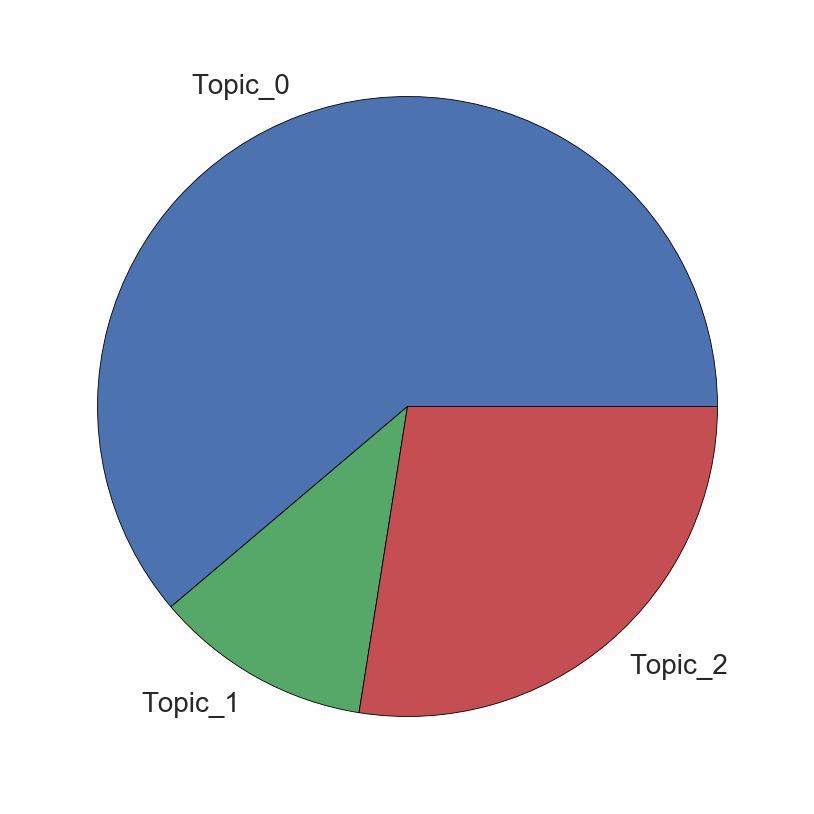

In [420]:
assign = []
for i in range(len(corpus_f)):
    assign.append(sorted(lda_f[corpus_f[i]],key = lambda x:x[1],reverse = True)[0][0])
conf_score = []
for i in range(len(corpus_f)):
    conf_score.append(sorted(lda[corpus_f[i]],key = lambda x:x[1],reverse = True)[0][1])
df_bow_f = pd.DataFrame({
             'corpus':corpus_f,
            'assign':list(map(lambda x:"Topic_"+str(x),assign)),
            'conf_score':conf_score,
                      'bow':filtered})
plt.figure(figsize = (5,5))
df_bow_f.groupby('assign').count()['bow'].plot(kind = 'pie')
plt.ylabel('')

In [325]:
del(list)
df_bow = pd.DataFrame({
             'corpus':corpus,
            'assign':list(map(lambda x:"Topic_"+str(x),assign)),
            'conf_score':conf_score,
                      'bow':cleaned_list_filtered})

** data is been saved in csv file 'topic assign.csv'**

In [326]:
df_bow.to_csv('topic_assign.csv')

In [382]:
topic_exp_all = ['spot',
 'aging',
 'inflammation',
 'technology',
 'Mask',
 'Psoriasis',
 'brighten',
 'skincare',
 'acne']

['spot',
 'aging',
 'inflammation',
 'technology',
 'Mask',
 'Psoriasis',
 'brighten',
 'skincare',
 'acne']

In [368]:
count_part = list(df_bow.groupby('assign').count()['corpus'].values)
count_part.extend([666,761])
count_part

[210, 320, 104, 368, 167, 210, 86, 666, 761]

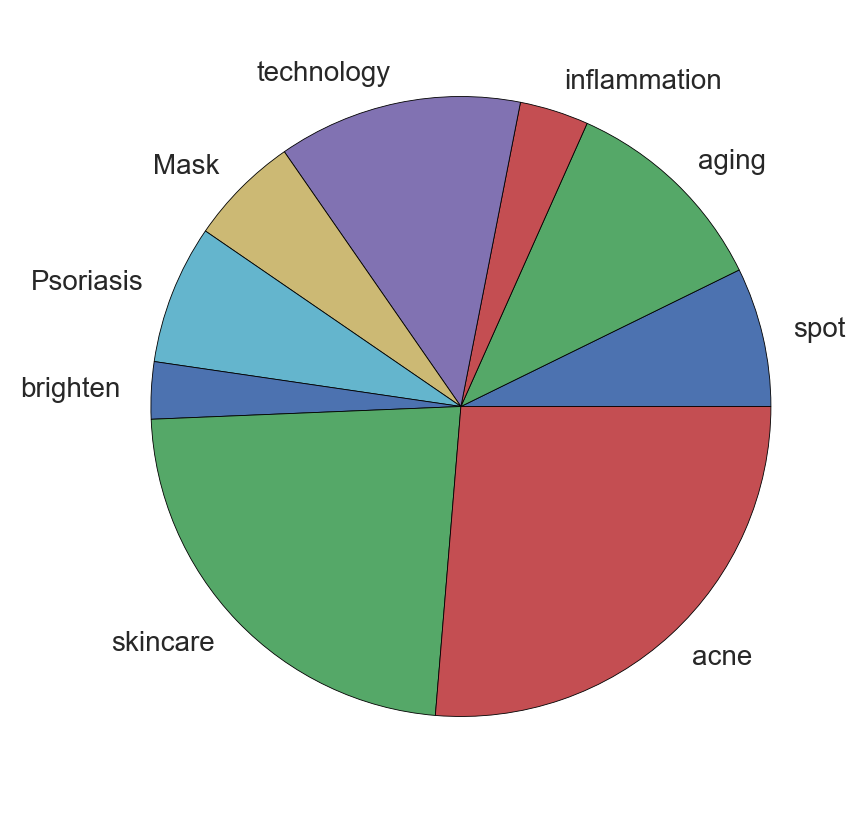

In [385]:
plt.figure(figsize = (5,5))
pd.DataFrame({'topic':topic_exp_all,'count':count_part}).set_index('topic')['count'].plot(kind = 'pie')
plt.ylabel('')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

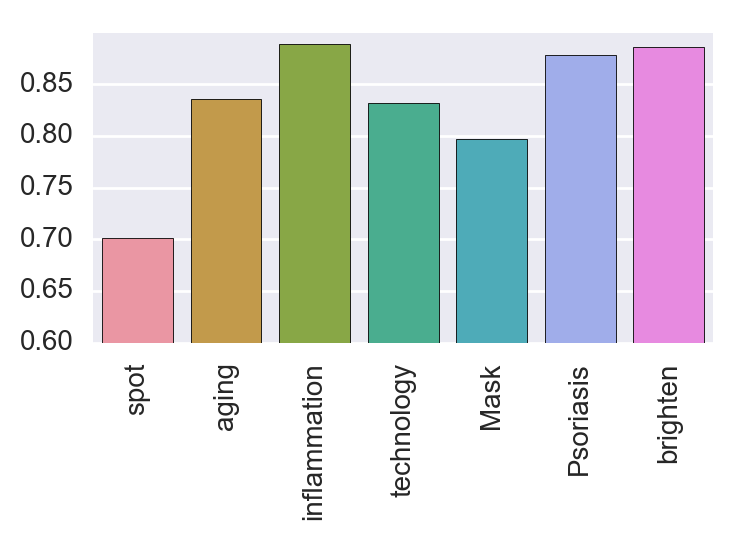

In [384]:
plt.figure(figsize=(4,2))
sns.barplot(x = topic_exp,y = df_bow.groupby('assign').mean()['conf_score'])
plt.ylim((0.6,0.9))
plt.ylabel('')
plt.xticks(rotation = 90)

In [353]:
#plt.figure(figsize=(5,5))
df_bow.groupby('assign').count()#.plot(kind = 'pie')
#plt.ylabel('')

,bow,conf_score,corpus
assign,,,
Topic_0,210,210,210
Topic_1,320,320,320
Topic_2,104,104,104
Topic_3,368,368,368
Topic_4,167,167,167
Topic_5,210,210,210
Topic_6,86,86,86


check the 8 category

In [54]:
for i in df_bow[df_bow['assign']==8]['original_text'].sample(10):
    print(i+'\n')

RT @DermaSpaDist: How Light Therapy Improves a #Microdermabrasion Treatment dermaspadistributors.com/best-facials-i?  #phototherapy #skincare pic.twitter.com/yb9XyqYJFF

RT @Theralight: Apparently, light therapy can do much more than treat depression!  Take a look at the #skincare possibilities! su.pr/1xpM95

RT @DermaSpaDist: How Light Therapy Improves a #Microdermabrasion Treatment dermaspadistributors.com/best-facials-i?  #phototherapy #skincare pic.twitter.com/yb9XyqYJFF

RT @Theralight: Apparently, light therapy can do much more than treat depression!  Take a look at the #skincare possibilities! su.pr/1xpM95

7 Colors LED Photon Facial Mask Skin Rejuvenation Light Therapy Reduces Wrinkles toys-and-hobbies.info/tysnd/hbbs026/? pic.twitter.com/AsAP9dTzG6

RT @Theralight: Apparently, light therapy can do much more than treat depression!  Take a look at the #skincare possibilities! su.pr/1xpM95

face mask always when watching #realitytv time to re watch the @PumpRules while I @BeautyK

** The model is confident in topic assignment over 80% of the time.**

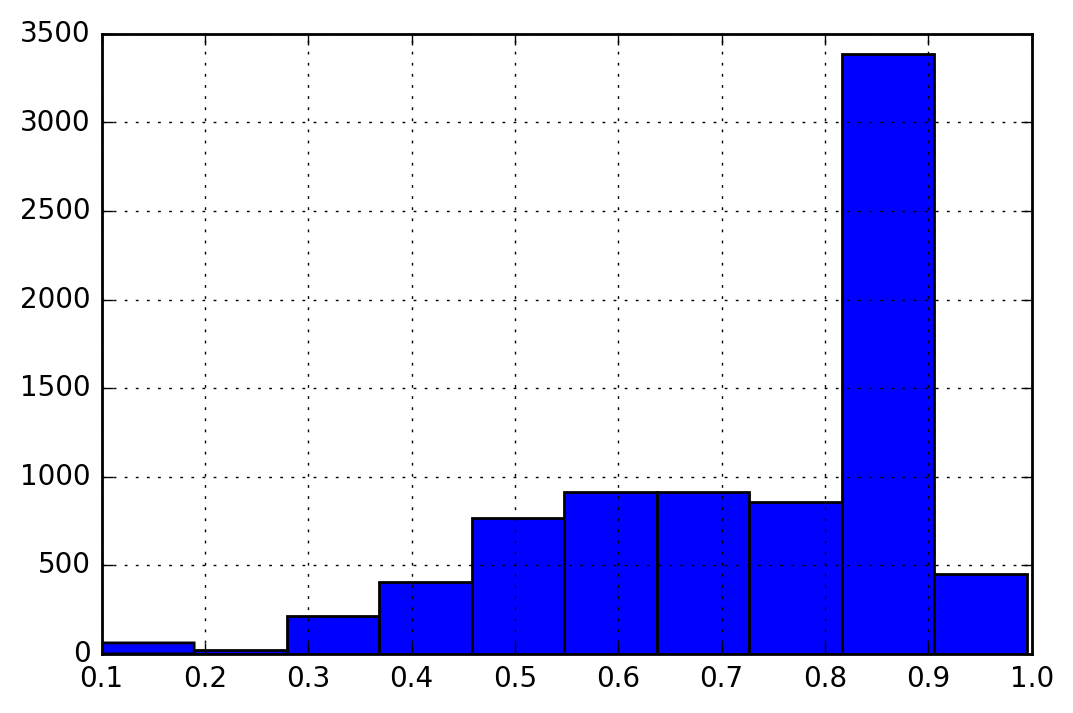

In [137]:
df_bow['conf_score'].hist()

** check records the model not sure of assignment :**

In [41]:
df_bow[df_bow['conf_score']<0.5][['bow','original_text']]

,bow,original_text
3,"[may, face, lotion, lite, review, two, favorit...","Sunday, May 1, 2016\n\nGlyDerm Face Lotion Lit..."
11,"[intranasal, infrared, heal, naturally]",$499 VieLight Intranasal Light Therapy 810 Inf...
31,"[skincare, issue, care]",have any #skincare issues? #olivegold03 and li...
48,"[health, acne, new, blue, color, skincare, acn...",RT @WXU_DEZ_025: #Health #Acne sherif.ws/acne/...
66,"[added, video, hair, mask, acne, lip, smacker]",I added a video to a @YouTube playlist youtu.b...
74,"[talking, away, winter, blue, posted, biologic...",Talking away the winter blues\n\nPosted by Bre...
103,"[attention, new, led, available, come, get, st]",Attention! New LED light therapy now available...
111,"[looking, device, help, shoulder, recover, sur...",While looking for a NIR light therapy device t...
112,"[also, wonder]",Light therapy also does wonders! Led-mask.com
154,"[love, led, face, mask, natural, suit, type, p...",Kourtney Kardashian loves the LED Face Mask.. ...


### Now we try to use TFIDF

In [251]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
num_topics = 8
lda_tfidf = LdaModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
lda_tfidf.show_topics(num_topics,15)

[(0,
  '0.034*"complete" + 0.034*"launching" + 0.034*"exciting" + 0.033*"day" + 0.032*"mask" + 0.024*"serious" + 0.024*"psoriasis" + 0.024*"condition" + 0.024*"used" + 0.023*"rosy" + 0.023*"many" + 0.023*"prolonged" + 0.023*"even" + 0.023*"cheek" + 0.023*"realize"'),
 (1,
  '0.020*"treat" + 0.019*"system" + 0.019*"serious" + 0.019*"psoriasis" + 0.018*"used" + 0.018*"condition" + 0.018*"watch" + 0.018*"natural" + 0.018*"video" + 0.018*"work" + 0.018*"dermatology" + 0.018*"aging" + 0.017*"kind" + 0.017*"right" + 0.017*"bring"'),
 (2,
  '0.040*"like" + 0.040*"look" + 0.024*"environment" + 0.024*"stop" + 0.024*"bus" + 0.024*"energy" + 0.024*"panel" + 0.024*"news" + 0.024*"winter" + 0.024*"brighten" + 0.023*"technology" + 0.018*"dermatology" + 0.017*"video" + 0.017*"work" + 0.017*"watch"'),
 (3,
  '0.040*"like" + 0.040*"look" + 0.025*"treat" + 0.022*"inflammation" + 0.022*"lady" + 0.022*"green" + 0.022*"edema" + 0.022*"lovely" + 0.022*"reducing" + 0.022*"exciting" + 0.022*"complete" + 0.022

In [60]:
assign = []
for i in range(len(corpus_tfidf)):
    assign.append(sorted(lda_tfidf[corpus_tfidf[i]],key = lambda x:x[1],reverse = True)[0][0])
conf_score = []
for i in range(len(corpus_tfidf)):
    conf_score.append(sorted(lda[corpus_tfidf[i]],key = lambda x:x[1],reverse = True)[0][1])

In [61]:
df_tfidf = pd.DataFrame({'original_text':content.content.values,
             'corpus':corpus,
            'assign':assign,
            'conf_score':conf_score,
                      'bow':cleaned_list})

** the model is less confident: **

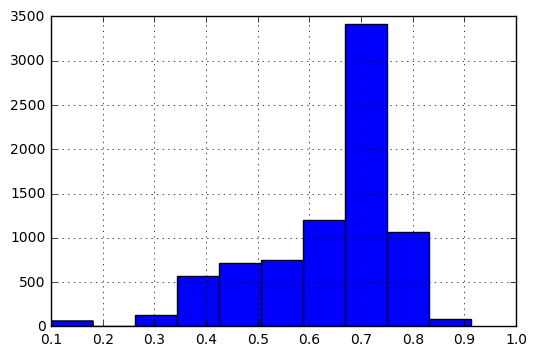

In [62]:
df_tfidf['conf_score'].hist()

** assignment is more evenly distributed: **

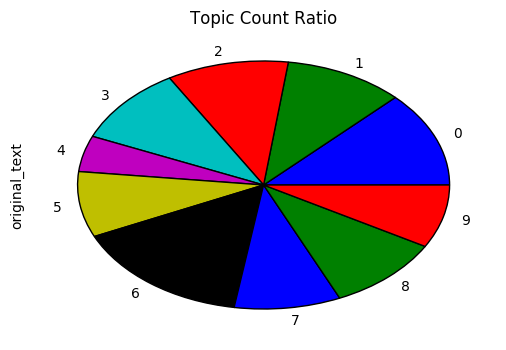

In [63]:
df_tfidf.groupby('assign').count()['original_text'].plot(kind='pie')
plt.title('Topic Count Ratio')
plt.figure(figsize=(5,5))

In [23]:
df_tfidf[df_tfidf['conf_score']<0.5][['bow','original_text']]

,bow,original_text
2,"[spotted, new, favorite, beauty, acne, mask]",@Star_news spotted @Olivia_Holt with her new f...
3,"[may, face, lotion, lite, review, two, favorit...","Sunday, May 1, 2016\n\nGlyDerm Face Lotion Lit..."
25,"[present, doc, peel, wonderful, experience]","#DmvNetworks presents\n\nDC Derm Docs\nBotox, ..."
31,"[skincare, issue, care]",have any #skincare issues? #olivegold03 and li...
48,"[health, acne, new, blue, color, skincare, acn...",RT @WXU_DEZ_025: #Health #Acne sherif.ws/acne/...
49,"[take, control, skincare]",Take control of your #rosacea with an #IPL #Ph...
53,"[color, led, light, photon, rejuvenation, lift...",4 Colors Led Light Therapy Lights Photon Rejuv...
63,"[improves, appearance, application]",RT @Theralight: #Photorejuvenation improves th...
83,"[interested, red, read, skincare]",Interested in having a Red Light Therapy?\nRea...
89,"[opera, led, mask, action, orchid, spa, wellne...",This is the OPERA LED facial mask in action at...


## part of speech 

** count unique **

In [118]:
deduplicated_df_pos.groupby('pos').count().sort(['word'],ascending = False)

C:\Users\mnan\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,word
pos,
NN,3128
JJ,1508
VBG,552
VBD,383
RB,345
VBN,211
VBP,147
NNS,140
VB,120


In [162]:
deduplicated_df_pos.to_csv('deduplicated_df_pos.csv')

** count **

In [66]:
sorted(dict(Counter(list(map(lambda x: x[1],sum(corpus_with_pos,[]))))).items(),key=operator.itemgetter(1),reverse = True)

[('NN', 46353),
 ('JJ', 16991),
 ('VBD', 4707),
 ('VBG', 4108),
 ('RB', 3319),
 ('VBN', 2654),
 ('VB', 2081),
 ('VBP', 1519),
 ('NNS', 1293),
 ('IN', 1263),
 ('CD', 533),
 ('VBZ', 470),
 ('JJR', 457),
 ('MD', 420),
 ('JJS', 332),
 ('FW', 175),
 ('RBR', 147),
 ('CC', 139),
 ('PRP', 137),
 ('DT', 99),
 ('NNP', 71),
 ('RBS', 39),
 ('RP', 36),
 ('WP', 33),
 ('WRB', 18),
 ('SYM', 12),
 ('UH', 8),
 ('EX', 6),
 ('WDT', 4),
 ('WP$', 2),
 ('PRP$', 1)]

** check pos interactively **

In [128]:
from ipywidgets import interact
from ipywidgets import Dropdown, FloatSlider
def print_pos(pos):
    
    print(deduplicated_df_pos[deduplicated_df_pos['pos']==pos]['word'])
    
col_list = list(deduplicated_df_pos['pos'].unique())
pos = Dropdown(options=col_list, value=col_list[0], description='Part of Speech')
interact(print_pos, pos=pos)

38              turn
72               see
97               get
116             hope
226            enjoy
245             make
386             tone
503             head
614             know
720           suffer
922          outcome
1030          supply
1044          wonder
1062            come
1063              go
1123            wash
1134            lose
1169            wave
1284            look
1328         include
1615            want
1719             say
1879        portrait
1892         receive
2159           trump
2222            tech
2230         believe
2282         provide
2424     combination
3045            give
            ...     
49640     blackberry
50829          rigor
54066         redeem
54120     oppressive
55637      esophagus
55923          robin
55984          rouse
56515        excerpt
60216           land
60986         reefer
63425            tar
64247     illuminate
64261          woven
64324          scarf
64804         legend
68039        suspect
69831        

In [129]:
keep_pos = ['JJ','JJS','JJR','NN','NNP','RB','VB','VBP','VBZ','RBR','VBD','VBN']

In [130]:
list(filter(lambda x: x[0] in keep_pos,dict(Counter(list(map(lambda x: x[1],sum(corpus_with_pos,[]))))).items()))

[('VBZ', 470),
 ('VBN', 2654),
 ('RBR', 147),
 ('VBP', 1519),
 ('JJR', 457),
 ('RB', 3319),
 ('JJ', 16991),
 ('NN', 46353),
 ('NNP', 71),
 ('VB', 2081),
 ('VBD', 4707),
 ('JJS', 332)]

In [131]:
filtered_corpus_with_pos=[]
for i in corpus_with_pos:
    filtered_corpus_with_pos.append(list(filter(lambda x: x[1] in keep_pos,i)))

In [132]:
filtered_corpus_by_pos = []
for i in filtered_corpus_with_pos:
    filtered_corpus_by_pos.append(list(map(lambda x: x[0],i)))

In [133]:
dictionary_pos = Dictionary(filtered_corpus_by_pos)
corpus_pos = [dictionary_pos.doc2bow(text) for text in filtered_corpus_by_pos]

In [134]:
tfidf_by_pos = models.TfidfModel(corpus_pos)
corpus_by_pos_tfidf = tfidf_by_pos[corpus_pos]
num_topics = 10
lda_pos_tfidf = LdaModel(corpus_by_pos_tfidf, id2word=dictionary_pos, num_topics=num_topics)
lda_pos_tfidf.show_topics(num_topics,10)

[(0,
  '0.106*"environment" + 0.105*"bus" + 0.103*"brighten" + 0.100*"stop" + 0.100*"panel" + 0.097*"news" + 0.090*"energy" + 0.087*"technology" + 0.084*"winter" + 0.006*"benefit"'),
 (1,
  '0.017*"remedy" + 0.016*"excellent" + 0.015*"care" + 0.015*"way" + 0.014*"equipment" + 0.014*"salon" + 0.014*"digital" + 0.013*"led" + 0.011*"safest" + 0.011*"consider"'),
 (2,
  '0.042*"violet" + 0.022*"prevent" + 0.020*"acne" + 0.020*"help" + 0.016*"blue" + 0.015*"estimated" + 0.014*"affect" + 0.013*"review" + 0.013*"video" + 0.012*"watch"'),
 (3,
  '0.022*"cause" + 0.021*"think" + 0.013*"skincare" + 0.013*"here" + 0.012*"got" + 0.012*"today" + 0.011*"industry" + 0.011*"hot" + 0.011*"quality" + 0.011*"perhaps"'),
 (4,
  '0.022*"revive" + 0.016*"essential" + 0.016*"complexion" + 0.015*"skincare" + 0.015*"step" + 0.013*"sassy" + 0.013*"winter" + 0.012*"grade" + 0.012*"beautification" + 0.010*"spa"'),
 (5,
  '0.021*"min" + 0.018*"led" + 0.017*"beauty" + 0.016*"matter" + 0.016*"photon" + 0.015*"intens

** try bigram **

In [118]:
bigram = gensim.models.Phrases(cleaned_list,min_count=1, threshold=2)
dictionary_text_list = list(bigram[cleaned_list])
train_text_list = list(bigram[cleaned_list])
dictionary_bigram = Dictionary(dictionary_text_list)
corpus_bigram = [dictionary_bigram.doc2bow(text) for text in train_text_list]

C:\Users\mnan\Anaconda3\lib\site-packages\gensim\models\phrases.py:248: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [119]:
num_topics = 10
lda_tfidf = LdaModel(corpus_bigram, id2word=dictionary_bigram, num_topics=num_topics)
lda.show_topics(num_topics,15)

[(0,
  '0.027*"violet" + 0.016*"benefit" + 0.015*"skin" + 0.010*"help" + 0.008*"low" + 0.007*"time" + 0.007*"black" + 0.007*"level" + 0.006*"red" + 0.005*"body" + 0.005*"muscle" + 0.005*"one" + 0.005*"mask" + 0.005*"led" + 0.004*"tone"'),
 (1,
  '0.056*"led" + 0.052*"skin" + 0.030*"wrinkle" + 0.026*"acne" + 0.015*"care" + 0.012*"ultrasound" + 0.012*"ultrasonic" + 0.012*"blue" + 0.011*"high" + 0.011*"red" + 0.010*"intensity" + 0.009*"machine" + 0.009*"focused" + 0.009*"collagen" + 0.008*"rt"'),
 (2,
  '0.019*"day" + 0.017*"new" + 0.017*"mask" + 0.014*"device" + 0.013*"rt" + 0.013*"exciting" + 0.013*"complete" + 0.012*"launching" + 0.011*"added" + 0.007*"medical" + 0.007*"led" + 0.007*"pub" + 0.005*"acne" + 0.005*"patient" + 0.005*"health"'),
 (3,
  '0.099*"led" + 0.061*"mask" + 0.056*"skin" + 0.048*"acne" + 0.042*"beauty" + 0.040*"photon" + 0.040*"rejuvenation" + 0.035*"new" + 0.028*"color" + 0.026*"blue" + 0.025*"red" + 0.018*"care" + 0.016*"sun" + 0.014*"face" + 0.012*"healing"'),
 (4

# Conclusion:

#### Bag of Words is the best